In [1]:
import sys
sys.path.append('../')
import pdb
import pycm
from glob import glob
import torch
from torch import nn
import cv2
import os
from PIL import Image
from skimage import io, transform
import matplotlib.pyplot as plt
import seaborn as sn
from models import get_model
import matplotlib.image as mpimg
import pandas as pd
from torchvision.datasets.folder import pil_loader
import random
import numpy as np
from torchsummary import summary
import pretrainedmodels
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import *
from tensorboard_logger import * 
from dataloader import *
from submission import *
from albumentations import torch as AT
from pycm import *
from mask_functions import *
os.environ['CUDA_VISIBLE_DEVICES']=""
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

#### plot test predicted masks

In [2]:
def get_rle_from_preds(preds, best_threshold, min_size=3500):
    '''takes in thresholded preds, returns rle for each pred in preds'''
    encoded_pixel = []
    for b in tqdm(range(num_test)):
        probability = preds[b, 0]
        if probability.shape != (1024, 1024):
            probability = cv2.resize(probability, dsize=(1024, 1024), interpolation=cv2.INTER_LINEAR)
        predictions, num_predict = post_process(probability, best_threshold, min_size)
        if num_predict == 0:
            encoded_pixel.append('-1')
        else:
            r = run_length_encode(predictions)
            encoded_pixel.append(r)
    return encoded_pixel

In [2]:
sample_df = pd.read_csv('../data/sample_submission.csv')

In [30]:
sub_csv = '../weights/68_UNet_f1_test/ckpt40test.csv'
sub = pd.read_csv(sub_csv)

In [31]:
sub.head()

ImageId_ClassId EncodedPixels
0  004f40c73.jpg_0           NaN
1  004f40c73.jpg_1           NaN
2  004f40c73.jpg_2           NaN
3  004f40c73.jpg_3           NaN
4  006f39c41.jpg_0           NaN

In [32]:
sub['ImageId'], sub['ClassId'] = zip(*sub['ImageId_ClassId'].str.split('_'))
sub['ClassId'] = sub['ClassId'].astype(int)
sub = sub.pivot(index='ImageId',columns='ClassId',values='EncodedPixels')
sub['defects'] = sub.count(axis=1)

In [33]:
sub.head()

ClassId          0    1                                                  2  \
ImageId                                                                      
004f40c73.jpg  NaN  NaN                                                NaN   
006f39c41.jpg  NaN  NaN                                                NaN   
00b7fb703.jpg  NaN  NaN  171571 12 171600 1 171603 1 171825 22 171848 1...   
00bbcd9af.jpg  NaN  NaN  154792 34 155036 54 155263 102 155499 139 1557...   
0108ce457.jpg  NaN  NaN                                                NaN   

ClassId                                                        3  defects  
ImageId                                                                    
004f40c73.jpg                                                NaN        0  
006f39c41.jpg                                                NaN        0  
00b7fb703.jpg                                                NaN        1  
00bbcd9af.jpg  298693 7 298702 1 298705 2 298708 2 298713 1 2...        2  
0108ce457.jpg                                                NaN        0

In [34]:
# Presence of defects in each images
no_defects_num = np.sum(sub['defects'] == 0)
defects_num = len(sub) - no_defects_num
print("no_defect imgs \t:", no_defects_num)
print("defects imgs \t:", defects_num)

no_defect imgs 	: 1336
defects imgs 	: 465


In [35]:
# Number of defects for each class
class_defects = len(sub) - sub.isnull().sum() # sum is default in axis=0
class_defects[:4]

ClassId
0     22
1      0
2    369
3    105
dtype: int64

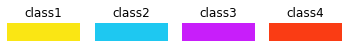

In [36]:
palet = [(250, 230, 20), (30, 200, 241), (200, 30, 250), (250,60,20)]

fig, ax = plt.subplots(1, 4, figsize=(6, 2))
for i in range(4):
    ax[i].axis('off')
    ax[i].imshow(np.ones((10, 40, 3), dtype=np.uint8) * palet[i])
    ax[i].set_title("class{}".format(i+1))

plt.show()

In [37]:
def mask2rgba(mask):
    rgba_list = []
    for idx in range(4):    # idx: class id
        rgba = cv2.cvtColor(mask[:, :, idx], cv2.COLOR_GRAY2RGBA)
        rgba[:, :, :3] = rgba[:, :, :3] /255 * palet[idx]
        rgba_list.append(rgba)
    return rgba_list

In [38]:
def make_mask(row_id):
    fname = sub.iloc[row_id].name
    labels = sub.iloc[row_id][:4]
    masks = np.zeros((256, 1600, 4), dtype=np.uint8)    # 4:class 1～4 (ch:0～3)

    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            mask = np.zeros(256 * 1600, dtype=np.uint8)
            for pos, le in zip(positions, length):
                mask[pos:(pos + le)] = 255
            masks[:, :, idx] = mask.reshape(256, 1600, order='F')
    return fname, masks


In [47]:
name, mask = make_mask(2)
name, mask.shape, np.unique(mask, return_counts=True)

('00b7fb703.jpg',
 (256, 1600, 4),
 (array([  0, 255], dtype=uint8), array([1629063,    9337])))

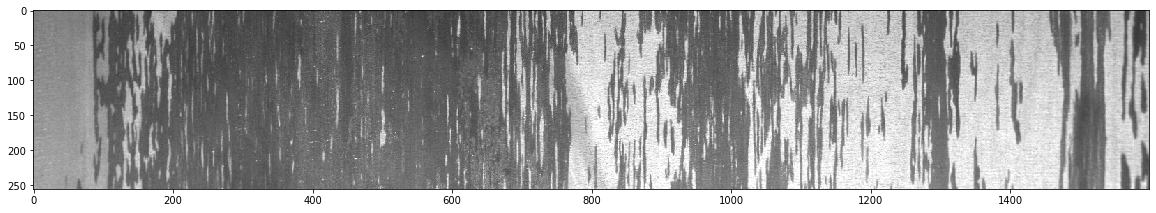

In [51]:
img = cv2.imread('../data/test_images/' + name)
plt.figure(figsize=(20, 10))
for ch in range(4):
    #img[mask[:, :, ch] == 255] = palet[ch]
    pass
plt.imshow(img)
plt.show()

In [3]:
npy_path = '../weights/48_UNet_f1_ft1024/ckpt38test%d.npy'
raw_preds = []
for count in range(10):
    npy = np.load(npy_path % count)
    raw_preds.extend(npy.tolist())
raw_preds = np.array(raw_preds)

KeyboardInterrupt: 

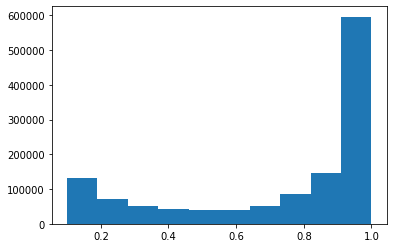

In [4]:
#npy_path = '../weights/28_UNet_f1_eq/ckpt24test.npy'
#npy_path = '../weights/38_UNet_f1_test/ckpt23test.npy'
npy_path = '../weights/38_UNet_f1_512/ckpt23test.npy'
sub_path = npy_path.replace('.npy', '.csv')
raw_preds = np.load(npy_path)
num_test = len(raw_preds)
preds = raw_preds[raw_preds > 0.1] # plot values above 0.1
plt.hist(preds.flatten());

In [5]:
best_threshold = 0.402
preds = predict(raw_preds, best_threshold)
encoded_pixel = get_rle_from_preds(preds, best_threshold, min_size=3000)
print(best_threshold, encoded_pixel.count('-1'), len(encoded_pixel))

0.402 1116 1372


1


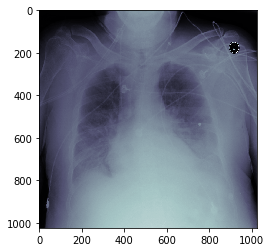

In [8]:
# take a look at encoded_pixels
try: i += 1
except: i = 0
print(i)
img_path = f"../data/test_png/{sample_df.iloc[i]['ImageId']}.png"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='bone')
#rle = df['EncodedPixels']
rle = encoded_pixel[i]
if rle!='-1':
    mask = run_length_decode(rle)
    plt.imshow(mask, alpha=0.3, cmap='Reds')
plt.show()

In [19]:
sub_df = sample_df.copy()
# sub_df['EncodedPixels'] = encoded_pixel
# sub_df.to_csv(sub_path, columns=['ImageId', 'EncodedPixels'], index=False)
sub_path = '../weights/48_UNet_f1_ft1024/ckpt38test.csv'
sub_df = pd.read_csv(sub_path)

In [20]:
print('Total negative preds:', sub_df.query('EncodedPixels=="-1"').shape[0])

Total negative preds: 1142


In [21]:
class_preds = pd.read_csv('../classifier/weights/2-8_efficientnet-b5_f1_/ckpt20test.csv')
class_preds['EncodedPixels'] = sub_df['EncodedPixels']
class_preds.head()

ImageId  \
0  1.2.276.0.7230010.3.1.4.8323329.6067.151787519...   
1  1.2.276.0.7230010.3.1.4.8323329.6214.151787519...   
2  1.2.276.0.7230010.3.1.4.8323329.6177.151787519...   
3  1.2.276.0.7230010.3.1.4.8323329.6655.151787519...   
4  1.2.276.0.7230010.3.1.4.8323329.6359.151787519...   

                                       EncodedPixels  label  
0                                                 -1      0  
1                                                 -1      0  
2  544859 4 1016 9 1012 14 1009 16 1007 17 1006 1...      1  
3                                                 -1      0  
4                                                 -1      0

In [22]:
neg = class_preds.query("label==0")
pos = class_preds.query("label==1")
neg.shape, pos.shape

((1045, 3), (327, 3))

In [23]:
correct = class_preds.query("(EncodedPixels == '-1' and label==0) or (EncodedPixels != '-1' and label==1)") # in accordance with classifier predictions
incorrect = class_preds.query("(EncodedPixels != '-1' and label==0) or (EncodedPixels == '-1' and label==1)") # not in accordance .. ^
print(f'According to classifier: correct preds: {correct.shape[0]}, incorrect preds: {incorrect.shape[0]}')

According to classifier: correct preds: 1157, incorrect preds: 215


In [24]:
print(sub_df.iloc[neg.index].query('EncodedPixels!="-1"').shape) # these many are going to be changed
print(sub_df.iloc[pos.index].query('EncodedPixels=="-1"').shape) # the segmentation model should have predicted something here. 

(59, 2)
(156, 2)


In [25]:
sub_df.loc[neg.index, 'EncodedPixels'] = "-1"

In [26]:
sub_df.to_csv(sub_path, columns=['ImageId', 'EncodedPixels'], index=False)

In [18]:
sub_df.head()

ImageId  \
0  1.2.276.0.7230010.3.1.4.8323329.6067.151787519...   
1  1.2.276.0.7230010.3.1.4.8323329.6214.151787519...   
2  1.2.276.0.7230010.3.1.4.8323329.6177.151787519...   
3  1.2.276.0.7230010.3.1.4.8323329.6655.151787519...   
4  1.2.276.0.7230010.3.1.4.8323329.6359.151787519...   

                                       EncodedPixels  
0                                                 -1  
1                                                 -1  
2  542812 5 1016 9 1012 13 1009 15 1007 18 1006 1...  
3                                                 -1  
4                                                 -1

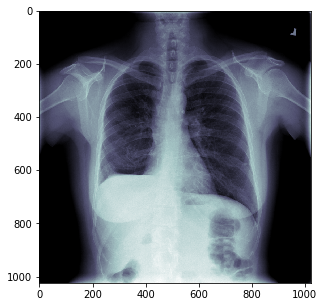

In [279]:
plt.figure(figsize=(5, 5))
try: i += 1 
except: i = 0
img_path = f"../data/test_png/{sub_df.iloc[i]['ImageId']}.png"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='bone')
rle = sub_df.iloc[i]['EncodedPixels']
if rle!='-1':
    mask = run_length_decode(rle)
    plt.imshow(mask, alpha=0.3, cmap='Reds')
    plt.title('1')
plt.show()

### Evaluate train predicted rle's

In [78]:
train_df = pd.read_csv('../data/train.csv')
train_df_pred = pd.read_csv('../weights/68_UNet_f1_test/ckpt25train.csv') 
train_df['pred'] = train_df_pred['EncodedPixels']
train_df = train_df.fillna('-1')
train_df['ImageId'], train_df['ClassId'] = zip(*train_df['ImageId_ClassId'].str.split('_'))
train_df['ClassId'] = train_df['ClassId'].astype(int)

In [80]:
train_df.head()

ImageId_ClassId                                      EncodedPixels pred  \
0  0002cc93b.jpg_1  29102 12 29346 24 29602 24 29858 24 30114 24 3...   -1   
1  0002cc93b.jpg_2                                                 -1   -1   
2  0002cc93b.jpg_3                                                 -1   -1   
3  0002cc93b.jpg_4                                                 -1   -1   
4  00031f466.jpg_1                                                 -1   -1   

         ImageId  ClassId  
0  0002cc93b.jpg        1  
1  0002cc93b.jpg        2  
2  0002cc93b.jpg        3  
3  0002cc93b.jpg        4  
4  00031f466.jpg        1

In [81]:
neg_pred = train_df.query('pred=="-1"').shape[0]
neg_gt = train_df.query('EncodedPixels=="-1"').shape[0]
print(f'Total cases: {train_df.shape[0]}')
print(f'Positive predictions/actual: {train_df.shape[0] - neg_pred} / {train_df.shape[0] - neg_gt}')
print(f'Negative predictions/actual: {neg_pred} / {neg_gt}')

Total cases: 50272
Positive predictions/actual: 4907 / 7095
Negative predictions/actual: 45365 / 43177


In [82]:
FPs = train_df.query('EncodedPixels == "-1" and pred != "-1"').shape[0] # FPs
FNs = train_df.query('EncodedPixels != "-1" and pred == "-1"').shape[0] # FNs
print(f'FPs: {FPs} | FNs: {FNs}')

FPs: 69 | FNs: 2257


001d3d093.jpg_1


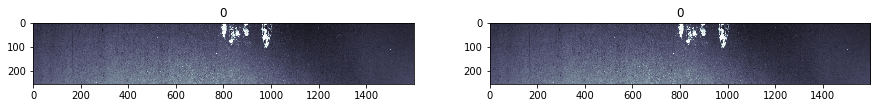

In [150]:
# take a look at encoded_pixels
plt.figure(figsize=(15, 15))
try: i += 1
except: i = 0
img_path = f"../data/train_images/{train_df.iloc[i]['ImageId']}"
print(train_df.iloc[i]['ImageId_ClassId'])
cls = train_df.iloc[i]['ClassId']
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='bone')
rle = train_df['EncodedPixels'][i]
pred_rle = train_df['pred'][i]
plt.title('0')
if rle!='-1':
    mask = rle2mask(rle)
    plt.title(f'gt: {cls}')
    plt.imshow(mask, alpha=0.2, cmap='Reds')
plt.subplot(1, 2, 2)
plt.imshow(img, cmap='bone')
plt.title('0')
if pred_rle!='-1':
    pred_mask = rle2mask(pred_rle)
    plt.title(f'pred: {cls}')
    plt.imshow(pred_mask, alpha=0.2, cmap='Reds')
plt.show()

In [173]:
TPs = train_df.query('EncodedPixels != "-1" and pred != "-1"').index
print(len(TPs))

4838


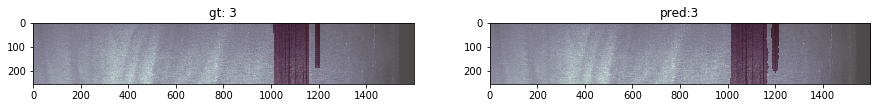

In [172]:
# take a look at some TPs 
plt.figure(figsize=(15, 15))
i = random.choice(TPs)
img_path = f"../data/train_images/{train_df.iloc[i]['ImageId']}"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='bone')
cls = train_df.iloc[i]['ClassId']
rle = train_df['EncodedPixels'][i]
pred_rle = train_df['pred'][i]
plt.title('0')
if rle!='-1':
    mask = rle2mask(rle)
    plt.title(f'gt: {cls}')
    plt.imshow(mask, alpha=0.3, cmap='Reds')
plt.subplot(1, 2, 2)
plt.imshow(img, cmap='bone')
plt.title('0')
if pred_rle!='-1':
    pred_mask = rle2mask(pred_rle)
    plt.title(f'pred:{cls}' )
    plt.imshow(pred_mask, alpha=0.3, cmap='Reds')
plt.show()

In [169]:
mask.sum()

16142.0

In [2]:
def get_uniques(path):
    '''takes predicted csv's and returns unique counts'''
    pred = pd.read_csv(path)
    print(np.unique(pred.diagnosis.values, return_counts=True))

# def get_preds(pred, threshold):
#     '''pred: [nx5], threshold: float'''
#     y1 = pred > threshold
#     y1 = np.clip(y1.astype(int).sum(axis=1) - 1, 0, 4)
#     return y1

def get_preds(arr, threshold, num_cls=5):
    """ takes in thresholded predictions (num_samples, num_cls) and returns (num_samples,)
    [3], arr needs to be a numpy array, NOT torch tensor"""
    arr = arr > threshold
    mask = arr == 0
    # pdb.set_trace()
    return np.clip(np.where(mask.any(1), mask.argmax(1), num_cls) - 1, 0, num_cls - 1)


def predict(X, coef):
    # [0.15, 2.4, ..] -> [0, 2, ..]
    X_p = np.copy(X)
    for i, pred in enumerate(X_p):
        if pred < coef[0]:
            X_p[i] = 0
        elif pred >= coef[0] and pred < coef[1]:
            X_p[i] = 1
        elif pred >= coef[1] and pred < coef[2]:
            X_p[i] = 2
        elif pred >= coef[2] and pred < coef[3]:
            X_p[i] = 3
        else:
            X_p[i] = 4
    return X_p.astype('int')



In [3]:
get_uniques('../weights/submission713.csv') 
get_uniques('../weights/submission736.csv') 
get_uniques('../weights/submission73.csv') 
get_uniques('../weights/submission785.csv') 
get_uniques('../weights/submission812.csv') 

(array([0, 1, 2, 3, 4]), array([227, 416, 931, 316,  38]))
(array([0, 1, 2, 3, 4]), array([292, 344, 998, 229,  65]))
(array([0, 1, 2, 3, 4]), array([ 301,  227, 1002,  345,   53]))
(array([0, 1, 2, 3, 4]), array([ 292,  180, 1178,  220,   58]))
(array([0, 1, 2, 3, 4]), array([ 331,  195, 1145,  193,   64]))


### Load predicted test npy files and compute the optimized threshold using the best public submission.csv

In [6]:
#npy_folder = '../weights/15-7_resnext101_32x4d_v0_fold0_bgcpold256/test_npy/'
#npy_folder = '../weights/17-7_resnext101_32x4d_v0_fold0_bgcpcold256reg/test_npy/'
#npy_folder = '../weights/18-7_resnext101_32x16d_fold0_bgccpold/test_npy/'
npy_folder = '../weights/24-7_efficientnet-b5_fold1_poscwwd/test_npy/'
files = glob(os.path.join(npy_folder, '*.npy'))
preds = {}
for file in files:
    ep = file.split('/')[-1]
    preds[ep] = np.load(file)
#preds.keys()

In [7]:
y_test = pd.read_csv('../weights/submission812.csv')['diagnosis'].values.reshape(-1, 1)

In [8]:
#cohen_kappa_score(y_test1, y_test, weights="quadratic")

In [9]:

def compute_dist(threshold, pred):
    y1 = get_preds(pred, threshold)
    #distance = np.mean((y1 - y_test)**2)
    score = cohen_kappa_score(y1, y_test, weights='quadratic')
    return 1 - score

def get_optimised_threshold(pred):
    initial_coeffs = np.array([0.5, 0.5, 0.5, 0.5, 0.5])
    simplex = scipy.optimize.minimize(
        compute_dist, initial_coeffs, args=(pred,), method='nelder-mead'
    )
    best_threshold = simplex['x']
    return best_threshold

for key in sorted(preds.keys(), key=lambda x: int(x.split('.')[0][9:])):
    pred, val_bt = preds[key]# val_bt = validation best threhsold
    #best_threshold = get_optimised_threshold(pred)
    best_threshold = val_bt
    base_threshold = np.array([0.5, 1.5, 2.5, 3.5])
    #print(f"\nval best thr: {val_bt}")
    print(f'\n{key}: {best_threshold}')
    pred1 = predict(pred, best_threshold)
    pred2 = predict(pred, base_threshold)
    score = cohen_kappa_score(y_test, pred1, weights="quadratic")
    acc = accuracy_score(y_test, pred1)
    print(f'score: {score}, acc: {acc}')
    print('best:', np.unique(pred1, return_counts=True)[1])
    print('base:', np.unique(pred2, return_counts=True)[1])


test_ckpt0.npy: [0.58215087 1.28804055 2.45846393 3.0179928 ]
score: 0.8319249388870249, acc: 0.7463692946058091
best: [ 368  250 1154  134   22]
base: [ 343  421 1031  129    4]

test_ckpt1.npy: [0.64150228 1.03384169 2.42293998 3.03479958]
score: 0.8614378259896601, acc: 0.7821576763485477
best: [ 388  129 1173  210   28]
base: [356 399 990 175   8]

test_ckpt2.npy: [0.50550003 1.47114944 2.51050568 3.51935959]
score: 0.8385835403300221, acc: 0.7396265560165975
best: [ 342  351 1037  191    7]
base: [ 341  369 1008  203    7]

test_ckpt3.npy: [0.50909362 1.43274436 2.47706747 3.54621568]
score: 0.8459575477750957, acc: 0.7510373443983402
best: [ 340  334 1056  192    6]
base: [ 338  387 1023  173    7]

test_ckpt4.npy: [0.49706118 1.26022344 2.53710389 3.03822568]
score: 0.8722682491689073, acc: 0.79201244813278
best: [ 335  237 1180  146   30]
base: [ 335  375 1029  184    5]

test_ckpt5.npy: [0.51342735 1.52359657 2.60932732 3.22859192]
score: 0.8593241959624852, acc: 0.7702282157

In [10]:
pred, th = preds['test_ckpt17.npy']
best_threshold = [0.5, 1.5, 2.5, 3.5]
pred_ = predict(pred, best_threshold)
print(np.unique(pred_, return_counts=True))
pred_ = predict(pred, th)
print(np.unique(pred_, return_counts=True))


(array([0, 1, 2, 3, 4]), array([ 315,  364, 1017,  223,    9]))
(array([0, 1, 2, 3, 4]), array([ 332,  293, 1114,  141,   48]))


### Analysis of model on train/val using cm obj files

In [2]:
train_cm = ConfusionMatrix(file=open('../weights/19-7_efficientnet-b5_fold1_bgccpold/logs/cmtrain_10.obj', 'r'))
val_cm = ConfusionMatrix(file=open('../weights/19-7_efficientnet-b5_fold1_bgccpold/logs/cmval_10.obj', 'r'))

In [6]:
ConfusionMatrix?

In [8]:
train_cm.predict_vector

In [3]:
train_cm.print_matrix()

Predict    0          1          2          3          4          
Actual
0          1904       77         6          1          0          

1          83         212        146        4          2          

2          16         88         839        123        1          

3          1          3          116        234        29         

4          0          1          45         82         118        




In [5]:
val_cm.print_matrix()

Predict   0         1         2         3         4         
Actual
0         314       11        1         0         0         

1         17        31        19        1         0         

2         3         18        131       8         0         

3         0         0         27        28        8         

4         0         0         9         11        18        




Effnet fold1, ckpt10 is my best performing model so far. LB: 0.812, 
Things to notice:
* Val thresholds optimized were used for val metric val_cm.

In [10]:
val_cm.overall_stat

{'Overall ACC': 0.7969465648854962,
 'Kappa': 0.6912228094240578,
 'Overall RACC': 0.3423949653283608,
 'SOA1(Landis & Koch)': 'Substantial',
 'SOA2(Fleiss)': 'Intermediate to Good',
 'SOA3(Altman)': 'Good',
 'SOA4(Cicchetti)': 'Good',
 'SOA5(Cramer)': 'Strong',
 'SOA6(Matthews)': 'Moderate',
 'TPR Macro': 0.6311902383922033,
 'PPV Macro': 0.6865924424290046,
 'ACC Macro': 0.9187786259541983,
 'F1 Macro': 0.6515875767370725,
 'TPR Micro': 0.7969465648854962,
 'PPV Micro': 0.7969465648854962,
 'F1 Micro': 0.7969465648854962,
 'Scott PI': 0.6908869944734718,
 'Gwet AC1': 0.7570484093907909,
 'Bennett S': 0.7461832061068702,
 'Kappa Standard Error': 0.023901986262936624,
 'Kappa 95% CI': (0.644374916348702, 0.7380707024994135),
 'Chi-Squared': 1028.5943993206718,
 'Phi-Squared': 1.57037312873385,
 'Cramer V': 0.6265726471714692,
 'Chi-Squared DF': 16,
 '95% CI': (0.7661391545353836, 0.8277539752356088),
 'Standard Error': 0.015718066505159483,
 'Response Entropy': 1.788741071801734,
 'Ref

In [9]:
np.mean(list(val_cm.class_stat['TPR'].values()))

0.6311902383922033

In [ ]:
def get_cms(pred_csv_path, fold, total_folds):
    '''useless, use cm_obj files instead'''
    '''takes predicted csv and fold, returns confusion matrices of train and validation set for that predictions'''
    preds = pd.read_csv(pred_csv_path)
    actual = pd.read_csv('../data/train.csv')
    df = preds.copy()
    df['pred'] = preds['diagnosis']
    df['actual'] = actual['diagnosis']
    df = df.drop('diagnosis', axis=1)
    # use `fold` to get the indices of train and val images in the actual df
    bad_indices = np.load('../data/bad_train_indices.npy')
    actual = actual.drop(df.index[bad_indices]) # remove duplicates having diff diagnosis
    kfold = StratifiedKFold(total_folds, shuffle=True, random_state=69)  # 20 splits
    train_idx, val_idx = list(kfold.split(actual["id_code"], actual["diagnosis"]))[fold]
    train_df, val_df = df.iloc[train_idx], df.iloc[val_idx]
    
    train_cm = ConfusionMatrix(train_df.actual.values, train_df.pred.values)
    val_cm = ConfusionMatrix(val_df.actual.values, val_df.pred.values)
    
    return train_cm, val_cm

In [ ]:
pred_csv_path = '../weights/10-7_densenet121_fold0_bengrahmscolor/ckpt38.csv'
fold = 0
total_folds=5
train_cm, val_cm = get_cms(pred_csv_path, fold, total_folds)

In [84]:
train_cm = ConfusionMatrix(file=open('../weights/8-7_resnext101_32x4d_fold6/logs/cmtrain_35.obj', 'r'))
val_cm = ConfusionMatrix(file=open('../weights/8-7_resnext101_32x4d_fold6/logs/cmval_35.obj', 'r'))

In [83]:
train_cm.print_matrix()

Predict    0          1          2          3          4          
Actual
0          1287       27         3          0          0          

1          20         465        53         2          13         

2          8          63         587        29         29         

3          0          1          35         203        30         

4          4          15         53         32         266        




In [85]:
val_cm.print_matrix()

Predict   0         1         2         3         4         
Actual
0         175       2         0         0         0         

1         2         26        6         0         2         

2         3         19        61        10        5         

3         0         0         3         10        6         

4         0         2         8         1         17        




In [34]:
cm = val_cm
cm.matrix

{0: {0: 314, 1: 11, 2: 1, 3: 0, 4: 0},
 1: {0: 17, 1: 31, 2: 19, 3: 1, 4: 0},
 2: {0: 3, 1: 18, 2: 131, 3: 8, 4: 0},
 3: {0: 0, 1: 0, 2: 27, 3: 28, 4: 8},
 4: {0: 0, 1: 0, 2: 9, 3: 11, 4: 18}}

In [35]:
cm.TP, cm.FP, cm.TN, cm.FN

({0: 314, 1: 31, 2: 131, 3: 28, 4: 18},
 {0: 20, 1: 29, 2: 56, 3: 20, 4: 8},
 {0: 309, 1: 558, 2: 439, 3: 572, 4: 609},
 {0: 12, 1: 37, 2: 29, 3: 35, 4: 20})

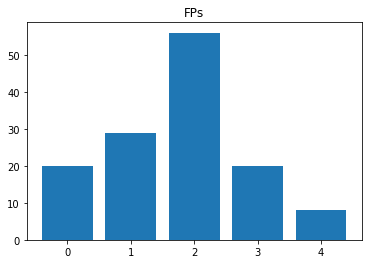

In [47]:
plt.bar(cm.FP.keys(), cm.FP.values())
plt.title('FPs');

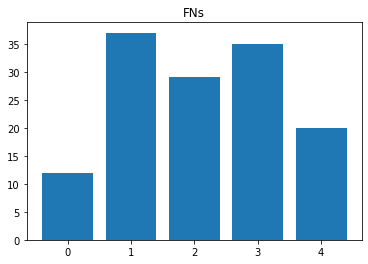

In [48]:
plt.bar(cm.FN.keys(), cm.FN.values())
plt.title('FNs');

### Let's plot some mispredictions

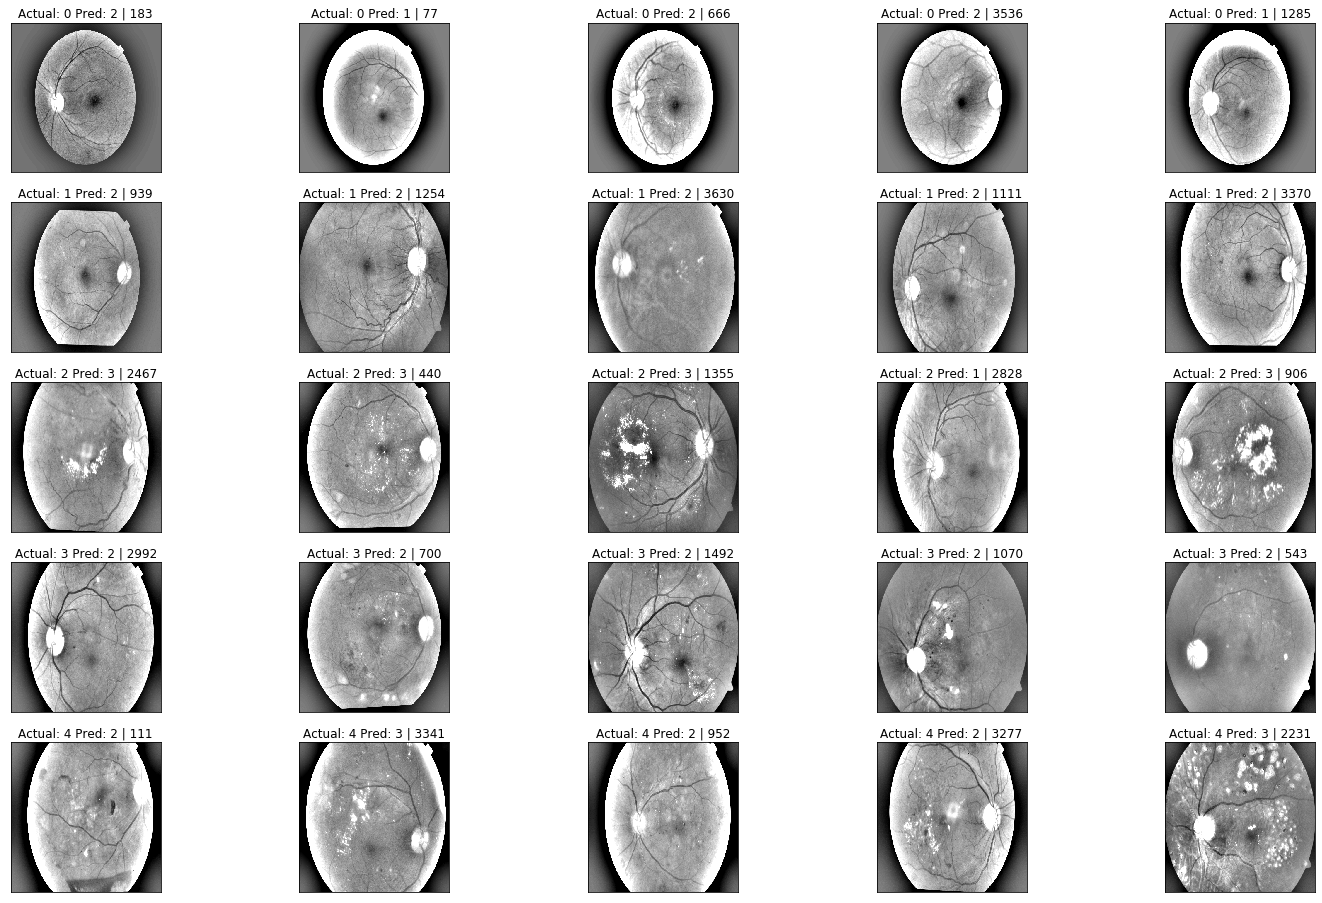

In [18]:
fig = plt.figure(figsize=(25, 16))
IMG_SIZE=512
for class_id in sorted(diff['actual'].unique()):
    samples = len(diff[diff['actual'] == class_id])
    samples = 5 if samples > 5 else samples # make sure there are atleast 5 predictions to plot or go for whatever is available
    for i, (idx, row) in enumerate(diff.loc[diff['actual'] == class_id].sample(samples, random_state=69).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"../data/train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , IMG_SIZE/10) ,-4 ,128) # the trick is to add this line
        plt.imshow(image, cmap='gray')
        ax.set_title('Actual: %d Pred: %d | %s' % (class_id, row['pred'], idx) )

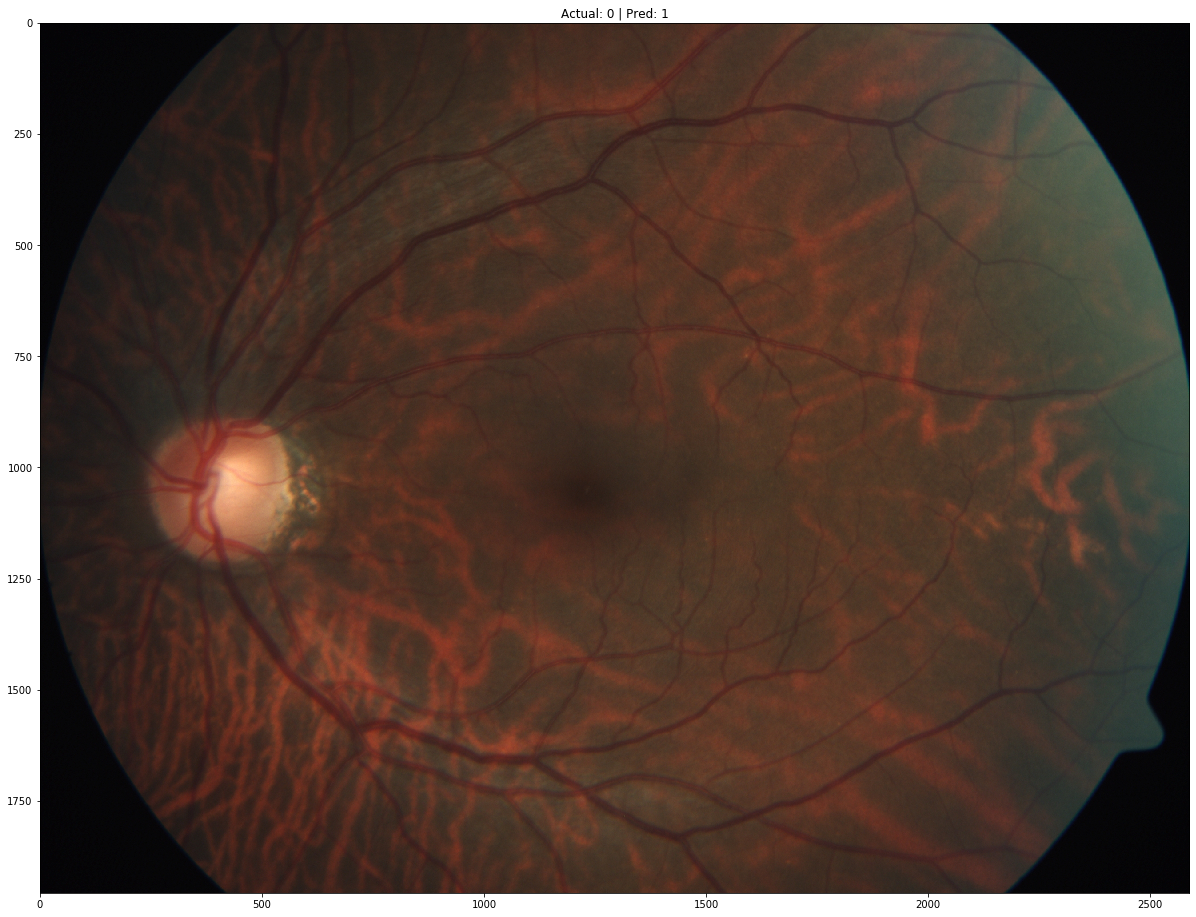

In [86]:
#i = 1546 
i = 494
#img = mpimg.imread() # remember the indices of diff are same as df
path = '../data/train_images/' + df.iloc[i]['id_code'] + '.png'
image = cv2.imread(path)
#image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
#|image=cv2.addWeighted (image, 4, cv2.GaussianBlur( image , (0,0) , IMG_SIZE/10) ,-4 ,128) # the trick is to add this line
fig = plt.figure(figsize=(25, 16))
#plt.imshow(image, cmap='gray')
plt.imshow(image, )
plt.title("Actual: %d | Pred: %d" % (df.iloc[i]['actual'], df.iloc[i]['pred']))
plt.show()

#####  https://www.eyeops.com/contents/our-services/eye-diseases/diabetic-retinopathy

In [87]:
image = cv2.resize(image, (IMG_SIZE, IMG_SIZE, 3))


TypeError: function takes exactly 2 arguments (3 given)

### Base model Activation heatmaps

In [9]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


In [10]:
model_name = "densenet121"
model = Model(model_name, 5)

In [11]:
model.model.features.norm5.register_forward_hook(get_activation('norm5'))

In [12]:
fold =0
total_folds = 10
images_folder = '../data/train_images/'
df_path = '../data/train.csv'
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
dataloaders = {
    phase: provider(
        fold,
        total_folds,
        images_folder,
        df_path,
        phase,
        size,
        mean,
        std,
        batch_size=1,
        num_workers=1,
    )
    for phase in ["train", "val"]
}

def unnormalize(img):
    mean = torch.as_tensor([0.485, 0.456, 0.406])
    std = torch.as_tensor([0.229, 0.224, 0.225])
    #return (img * std) + mean
    for t, m, s in zip(img, mean, std):    
        t.mul_(s).add_(m)
    return img.permute(1, 2, 0)# * 255

In [51]:
batch = next(iter(dataloaders['train']))

In [52]:
fnames, images, labels = batch
output = model(images) # during forward pass, model populates the activation dictionary using forward hook

In [53]:
act = activation['norm5'] # 1, 1024, 7, 7
mean_act = torch.mean(act[0], 0) # take mean across 1024 channels

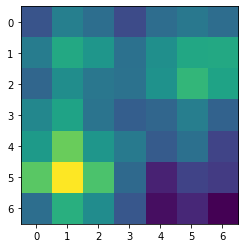

In [54]:
plt.imshow(mean_act, cmap='viridis')

In [55]:
unimage = unnormalize(images[0].clone())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


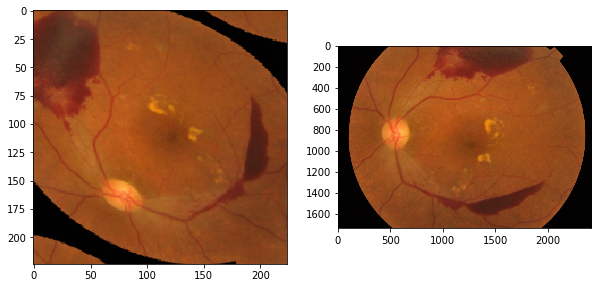

In [63]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(unimage);
plt.subplot(1, 2, 2)
plt.imshow(mpimg.imread(f'../data/train_images/{fnames[0]}.png')); 
plt.show(); # original image

In [84]:
torch.max(unimage), torch.min(unimage)

(tensor(0.8902), tensor(0.))

In [87]:
torch.max(images), torch.min(images)

(tensor(1.7694), tensor(-2.1179))

### Where's model failing? Hard examples? Analysing train set

In [12]:
#train_pred, best_thresholds = np.load('../weights/21-7_efficientnet-b5_fold1_bgccpo300aug2/train_npy/train_ckpt15.npy')
train_pred, best_thresholds = np.load('../weights/24-7_efficientnet-b5_fold1_poscwwd/train_npy/train_ckpt29.npy')
base_th = [0.5, 1.5, 2.5, 3.5]
train_bestpred = predict(train_pred, best_thresholds)
train_basepred = predict(train_pred, base_th)

In [13]:
train_df = pd.read_csv('../data/train.csv')
train_df['bestpred'] = train_bestpred
train_df['basepred'] = train_basepred

In [14]:
train_df.head()

id_code  diagnosis  bestpred  basepred
0  000c1434d8d7          2         2         2
1  001639a390f0          4         4         4
2  0024cdab0c1e          1         1         1
3  002c21358ce6          0         0         0
4  005b95c28852          0         0         0

In [15]:
# qwk in bestpred, basepred
cohen_kappa_score(train_df['basepred'].values, train_df['bestpred'].values, weights="quadratic" )

0.9797408346863566

In [16]:
cohen_kappa_score(train_df['bestpred'].values, train_df['diagnosis'].values, weights="quadratic" )

0.934265636156262

In [17]:
base_diff = train_df.query("diagnosis != basepred")
best_diff = train_df.query("diagnosis != bestpred")

In [18]:
base_diff.shape, best_diff.shape # base_diff > best_diff means best_thresholds is better

((576, 4), (510, 4))

In [19]:
cohen_kappa_score(best_diff['bestpred'].values, best_diff['diagnosis'].values, weights="quadratic" )

0.3672952361053071

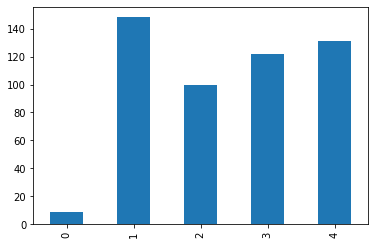

In [34]:
best_diff['diagnosis'].value_counts(sort=False).plot('bar');

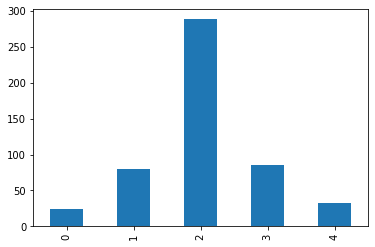

In [35]:
best_diff['bestpred'].value_counts(sort=False).plot('bar');

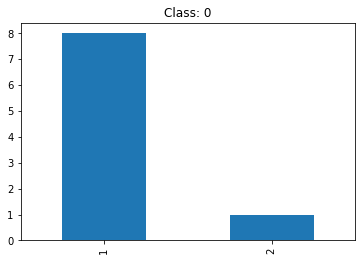

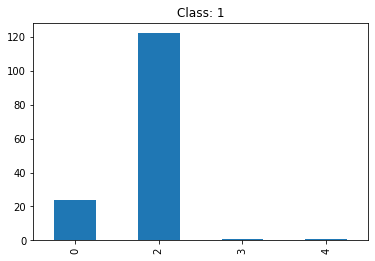

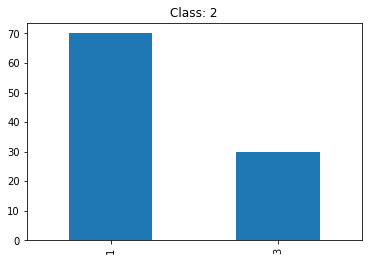

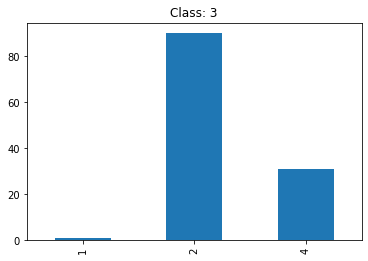

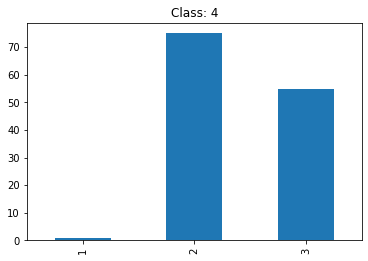

In [38]:
for i in range(5): best_diff[best_diff['diagnosis']==i]['bestpred'].value_counts(sort=False).plot(kind="bar", title=f'Class: {i}'); plt.show()

In [39]:
cm = ConfusionMatrix(best_diff['diagnosis'].values, best_diff['bestpred'].values)

In [40]:
cm.print_matrix()

Predict   0         1         2         3         4         
Actual
0         0         8         1         0         0         

1         24        0         122       1         1         

2         0         70        0         30        0         

3         0         1         90        0         31        

4         0         1         75        55        0         




A lot of 1's are being predicted as 2, 2's are equally distributed to 1 and 3, 4's are being predicted as 3

In [41]:
best_diff.head()

id_code  diagnosis  bestpred  basepred
13  0104b032c141          3         2         3
32  0243404e8a00          4         2         2
34  02685f13cefd          4         3         3
40  0318598cfd16          4         2         2
45  0369f3efe69b          1         2         2

In [42]:
best_diff.index # indices of hard examples


Int64Index([  13,   32,   34,   40,   45,   46,   47,   49,   56,   61,
            ...
            3620, 3627, 3631, 3634, 3639, 3642, 3650, 3655, 3656, 3659],
           dtype='int64', length=510)

In [43]:
# hard_ex_indices = best_diff.index.tolist()
# train_df = pd.read_csv('../data/train.csv')
# train_df['weight'] = 1
# train_df.at[hard_ex_indices, 'weight'] = 2
# train_df.head()

#### Extremely hard examples

In [44]:
best_diff['dist'] = abs(best_diff['bestpred'] - best_diff['diagnosis'])

In [45]:
best_diff.head()

id_code  diagnosis  bestpred  basepred  dist
13  0104b032c141          3         2         3     1
32  0243404e8a00          4         2         2     2
34  02685f13cefd          4         3         3     1
40  0318598cfd16          4         2         2     2
45  0369f3efe69b          1         2         2     1

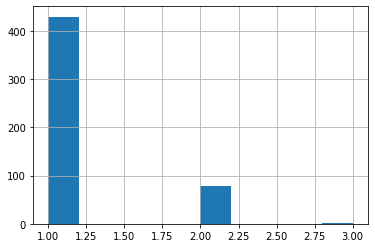

In [46]:
best_diff['dist'].hist()

In [47]:
extremely_hard_examples = best_diff.query('dist>1')

In [48]:
extremely_hard_examples.shape

(80, 5)

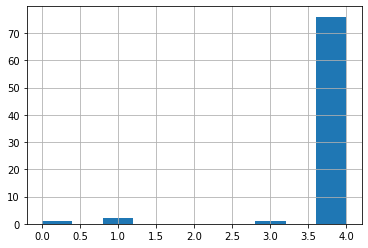

In [49]:
extremely_hard_examples['diagnosis'].hist()

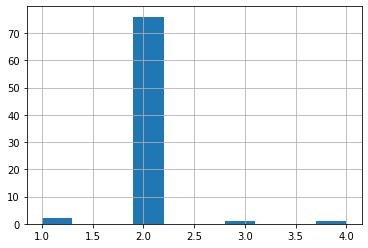

In [50]:
extremely_hard_examples['bestpred'].hist()

In [51]:
excm = ConfusionMatrix(extremely_hard_examples['diagnosis'].values, extremely_hard_examples['bestpred'].values)
excm.print_matrix()

Predict  0        1        2        3        4        
Actual
0        0        0        1        0        0        

1        0        0        0        1        1        

2        0        0        0        0        0        

3        0        1        0        0        0        

4        0        1        75       0        0        




Extremely hard examples are from class 4, being predicted as 2, If I fix this issue, boi the score is gonna improve

###### Let's visualize these extremely hard examples

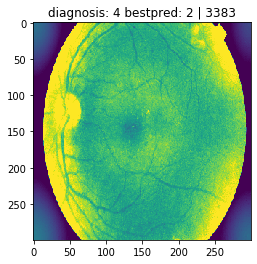

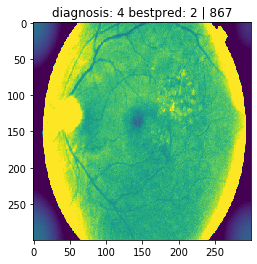

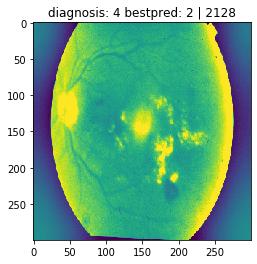

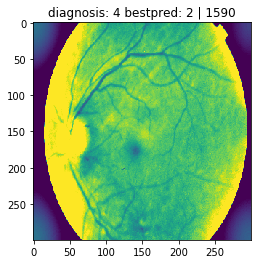

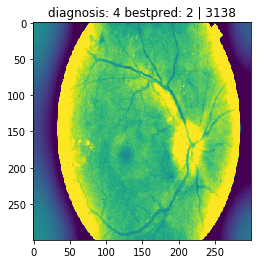

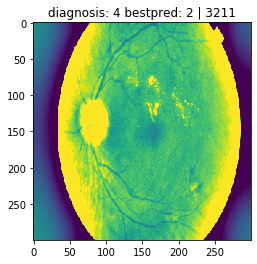

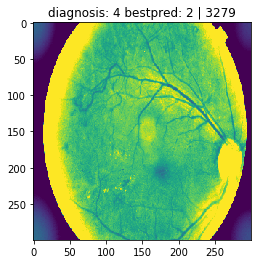

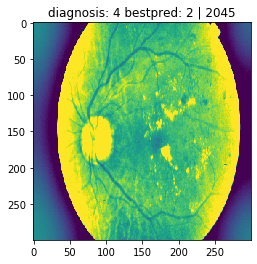

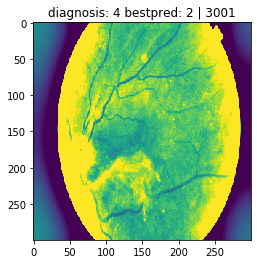

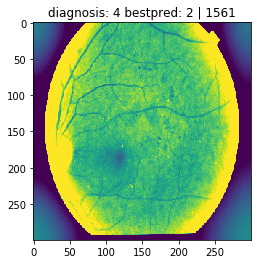

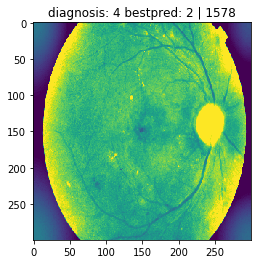

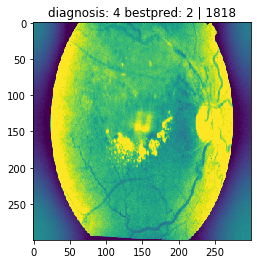

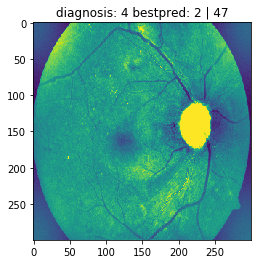

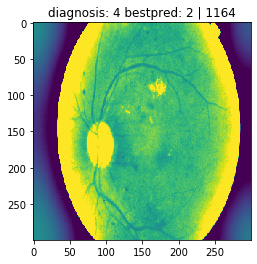

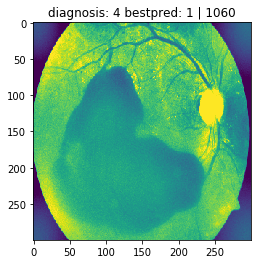

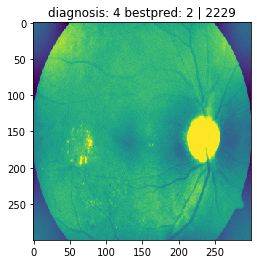

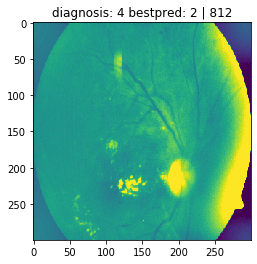

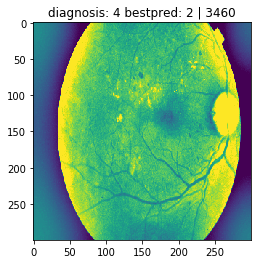

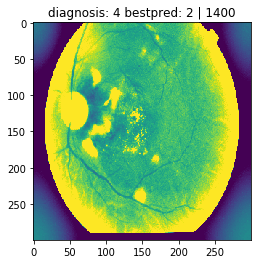

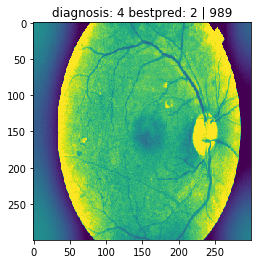

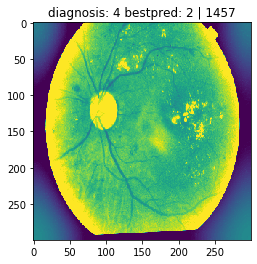

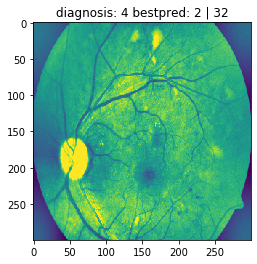

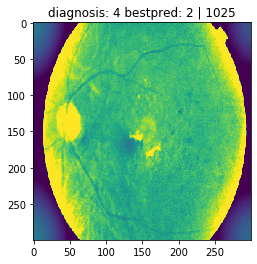

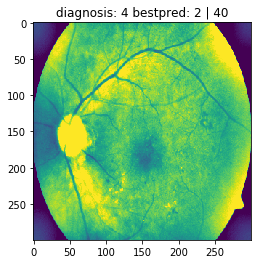

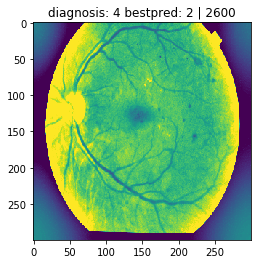

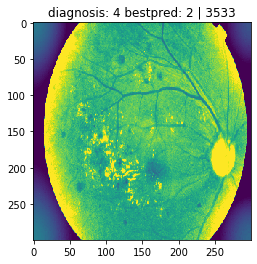

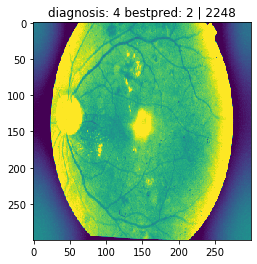

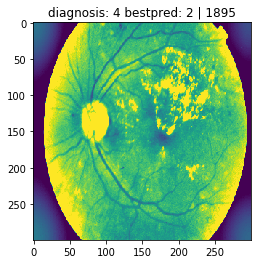

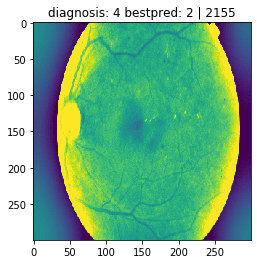

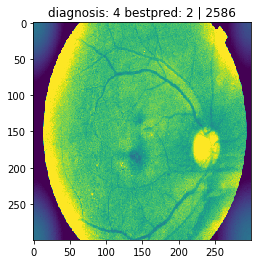

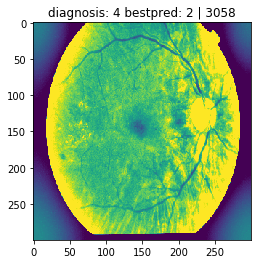

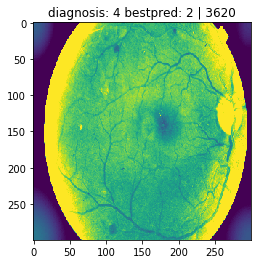

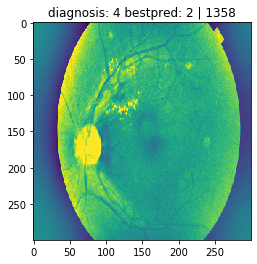

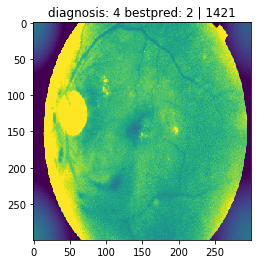

In [49]:
#fig = plt.figure(figsize=(25, 16))
IMG_SIZE=300
# for class_id in sorted(extremely_hard_examples['diagnosis'].unique()):
class_id = 4
samples = len(extremely_hard_examples[extremely_hard_examples['diagnosis'] == class_id])
for i, (idx, row) in enumerate(extremely_hard_examples.loc[extremely_hard_examples['diagnosis'] == class_id].sample(samples, random_state=69).iterrows()):
    path=f"../data/train_images/{row['id_code']}.png"
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , IMG_SIZE/10) ,-4 ,128) # the trick is to add this line
    plt.imshow(image)
    plt.title('diagnosis: %d bestpred: %d | %s' % (class_id, row['bestpred'], idx) )
    plt.show()

In [89]:
#np.save('../data/extremely_hard_examples1.npy', extremely_hard_examples.index.values)

ehe = np.load('../data/extremely_hard_examples1.npy')


In [90]:
ehe

array([  32,   40,   47,   82,  147,  177,  290,  385,  433,  534,  771,
        867,  964,  989, 1025, 1164, 1292, 1358, 1457, 1461, 1561, 1563,
       1578, 1590, 1655, 1728, 1895, 2015, 2055, 2119, 2155, 2164, 2229,
       2248, 2331, 2600, 2661, 2735, 2776, 2797, 2802, 2961, 2992, 2997,
       3013, 3142, 3211, 3277, 3279, 3287, 3332, 3341, 3383, 3533, 3545,
       3620])

In [91]:
len([x for x in ehe if x in extremely_hard_examples.index]), len(ehe)

(24, 56)

In [57]:
#np.save('../data/hard_examples1.npy', best_diff.index.values)

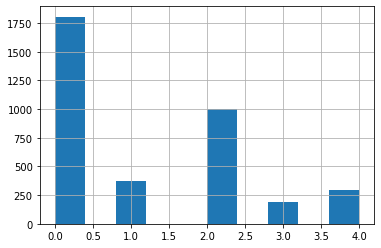

In [38]:
train_df['diagnosis'].hist()

### Why is there so much variation in the test predictions?

In [52]:
# let's generate multiple test predictions from a same model

In [171]:
test0, best_thresholds = np.load('../weights/23-7_efficientnet-b5_fold1_po3005e-6/test_npy/test_ckpt28_0.npy')
test = {
    0: test0
}
for i in range(1, 5):
    test[i] = np.load(f'../weights/23-7_efficientnet-b5_fold1_po3005e-6/test_npy/test_ckpt28_{1}.npy')[0]

In [172]:
pred = {}
for i in range(5):
    pred[i] = predict(test[i], best_thresholds)

In [173]:
df = pd.DataFrame()

In [174]:
for i in range(5):
    df[f'pred{i}'] = pred[i].reshape(-1)

In [175]:
df.head()

pred0  pred1  pred2  pred3  pred4
0      2      2      2      2      2
1      3      3      3      3      3
2      3      3      3      3      3
3      2      2      2      2      2
4      2      2      2      2      2

In [176]:
df.query('pred0 == pred1 == pred2 == pred3 == pred4').shape, df.shape

((1861, 5), (1928, 5))

with tta=2: 1928 - 1824 = 104 cases are varying. 0:55
#with tta=4: 99 cases are varying. 1:22
#with tta=5: 89 cases are varying. 1:22
#with tta=6: 76 cases are varying. 1:48 minutes per epoch
#with tta=6: 94 cases are varying. 1:48 minutes per epoch
#with tta=8: 88 cases are varying. 2:15 minutes per epoch
#with tta=10: 67
#with no tta, got ZERO variation, all predictions were same